# Deep Learning based Email Spam Filter


# Introduction 
We will create the email spam filter model using deep learning and evaluate the model with other currently popular machine learning methods like xgboost, random forest, svm etc.

For this sample project, we will use Enron dataset in English. However this approach works well for other languages also which i had empiricially tested in my job. 

This approach is combining unsupervised learning with Supervised learning. We will generate the features in unsupervised way using TF-IDF algorithm and then use this to features to train Models on labeled enron data. 

The code and data for this project can be obtained at : 
https://github.com/sanjaymeena/Deep-Learning-based-Spam-Filter






The broad steps can be divided as : 

## 1. Preprocessing:

Here we will generate a pandas dataframe from the enron dataset . We will tokenize and also do some data analysis  
## 2.  Features Generation (Unsupervised Learning)  

We will use [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) as features to be used for training the models. 


## 3. Model Training 

* We will train a 3-layered deep learning model. 
* We will also train Random forest, SVM  and Xgboost for comparison purpose.
* We will the same tf-idf features for all the models 

## 4. Result Analysis and iterate to improve the performnce

* We will present our results in nice and informative way to provide good comparison information. 

# 1. Preprocessing 

In [7]:
# Load required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
import pickle
import seaborn as sns
import sys
sys.setrecursionlimit(1500)
%matplotlib inline


# Preparing Enron Data 

We will extract and load the Enron spam data in Pandas Dataframe.

Enron data combined with Spam assasin dataset has been obtained from : https://www.cs.bgu.ac.il/~elhadad/nlp16/spam_classifier.html and I  also used their code to process the data into Pandas dataframe

In [8]:
def progress(i, end_val, bar_length=50):
    '''
    Print a progress bar of the form: Percent: [#####      ]
    i is the current progress value expected in a range [0..end_val]
    bar_length is the width of the progress bar on the screen.
    '''
    percent = float(i) / end_val
    hashes = '#' * int(round(percent * bar_length))
    spaces = ' ' * (bar_length - len(hashes))
    sys.stdout.write("\rPercent: [{0}] {1}%".format(hashes + spaces, int(round(percent * 100))))
    sys.stdout.flush()

NEWLINE = '\n'

In [9]:
HAM = 'ham'
SPAM = 'spam'

SOURCES = [
    ('../data/enron//spam',        SPAM),
    ('../data/enron//easy_ham',    HAM),
    ('../data/enron//hard_ham',    HAM),
    ('../data/enron//beck-s',      HAM),
    ('../data/enron//farmer-d',    HAM),
    ('../data/enron//kaminski-v',  HAM),
    ('../data/enron//kitchen-l',   HAM),
    ('../data/enron//lokay-m',     HAM),
    ('../data/enron//williams-w3', HAM),
    ('../data/enron//BG',          SPAM),
    ('../data/enron//GP',          SPAM),
    ('../data/enron//SH',          SPAM)
]

SKIP_FILES = {'cmds'}
NEWLINE="\n"

def read_files(path):
    '''
    Generator of pairs (filename, filecontent)
    for all files below path whose name is not in SKIP_FILES.
    The content of the file is of the form:
        header....
        <emptyline>
        body...
    This skips the headers and returns body only.
    '''
    for root, dir_names, file_names in os.walk(path):
        for path in dir_names:
            read_files(os.path.join(root, path))
        for file_name in file_names:
            if file_name not in SKIP_FILES:
                file_path = os.path.join(root, file_name)
                if os.path.isfile(file_path):
                    past_header, lines = False, []
                    f = open(file_path, encoding="latin-1")
                    for line in f:
                        if past_header:
                            lines.append(line)
                        elif line == NEWLINE:
                            past_header = True
                    f.close()
                    content = NEWLINE.join(lines)
                    yield file_path, content


def build_data_frame(l, path, classification):
    rows = []
    index = []
    for i, (file_name, text) in enumerate(read_files(path)):
        if ((i+l) % 100 == 0):
            progress(i+l, 58910, 50)
        rows.append({'text': text, 'label': classification,'file':file_name})
        index.append(file_name)
   
    data_frame = pd.DataFrame(rows, index=index)
    return data_frame, len(rows)

def load_data():
    data = pd.DataFrame({'text': [], 'label': [],'file':[]})
    l = 0
    for path, classification in SOURCES:
        data_frame, nrows = build_data_frame(l, path, classification)
        data = data.append(data_frame)
        l += nrows
    data = data.reindex(np.random.permutation(data.index))
    return data

In [10]:
# We will load the Email spam dataset into Panadas dataframe here . 
data=load_data()



Percent: [################################################  ] 96%

In [11]:
# We change the dataframe index from filenames to indices here. 

In [12]:
new_index=[x for x in range(len(data))]
data.index=new_index


We will add two more columns to our dataframe for tokenized text and token count. 

In [13]:
def token_count(row):
    'returns token count'
    text=row['tokenized_text']
    length=len(text.split())
    return length

def tokenize(row):
    "tokenize the text using default space tokenizer"
    text=row['text']
    lines=(line for line in text.split(NEWLINE) )
    tokenized=""
    for sentence in lines:
        tokenized+= " ".join(tok for tok in sentence.split())
    return tokenized


We will use apply functions on dataframe to add the columns for : 
    * Tokenized text
    * Token Count
    * Language
Language column in this case is not necessary as we only have english text. However this approach is good for properly dealing with multi lingual data.     

In [14]:
data['tokenized_text']=data.apply(tokenize, axis=1)


In [15]:
data['token_count']=data.apply(token_count, axis=1)


In [16]:
data['lang']='en'

Let's look at how our dataframe looks like

In [17]:
data.head()

,text,label,file,tokenized_text,token_count,lang
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",spam,../data/enron//GP\part1\msg154.eml,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",786,en
1,"Go to http://www.winedt.com/, select downloads...",ham,../data/enron//kaminski-v\c_technote_mail_tech...,"Go to http://www.winedt.com/, select downloads...",93,en
2,This is a multi-part message in MIME format.\n...,spam,../data/enron//SH\HP\prodmsg.2.448492.2005720,This is a multi-part message in MIME format.--...,169,en
3,-------- Original Message --------\n\nSubject:...,ham,../data/enron//lokay-m\personal\3,-------- Original Message --------Subject: RE:...,223,en
4,Earl - I have a meter with flow and no nom. M...,ham,../data/enron//farmer-d\logistics\2101,Earl - I have a meter with flow and no nom. Me...,35,en


In [18]:
# Lets look at some information related to the data

In [19]:
df=data
print("total emails : ", len(df))
print  ("total spam emails : ", len(df[df['label']=='spam']) )
print  ("total normal emails : ", len(df[df['label']=='ham']) )

total emails :  56523
total spam emails :  32978
total normal emails :  23545


### Plot of Emails with Langage and Email type

C:\Users\User\AppData\Local\Temp/ipykernel_20100/3295613192.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df1 = df.groupby(['lang','label'])['label','lang'].size().unstack()


Text(0.5, 1.0, 'Plot of Emails count with languages and email type')

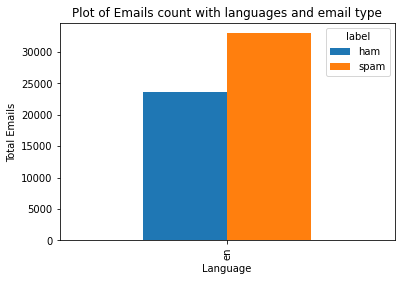

In [20]:
df1 = df.groupby(['lang','label'])['label','lang'].size().unstack()

ax=df1.plot(kind='bar')
ax.set_ylabel("Total Emails")
ax.set_xlabel("Language")
ax.set_title("Plot of Emails count with languages and email type")



Text(0.5, 1.0, 'Token length Vs Frequency for Enron Spam Emails')

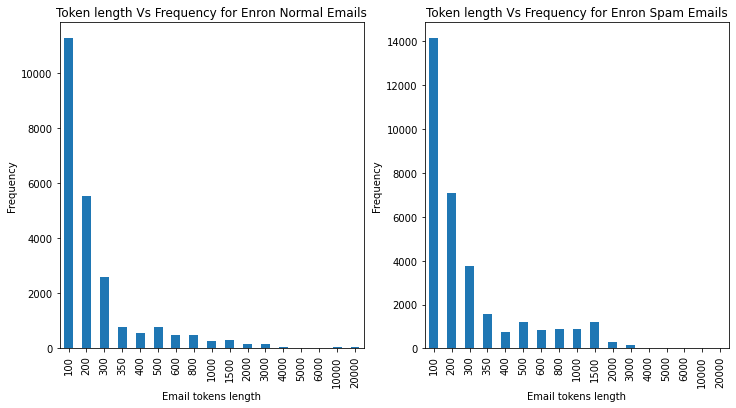

In [21]:
bins = [0,100,200,300,350,400,500,600,800,1000,1500,2000,3000,4000,5000,6000,10000,20000]


fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 6))
fig.subplots_adjust(hspace=.5)

df_sub=df[ (df['lang']=='en') & (df['label']=='ham')]
df1 = df_sub.groupby(pd.cut(df_sub['token_count'], bins=bins)).token_count.count()
df1.index=[a.right for a in df1.index]
res1=df1.plot(kind='bar',ax=axes[0])
res1.set_xlabel('Email tokens length')
res1.set_ylabel('Frequency')
res1.set_title('Token length Vs Frequency for Enron Normal Emails')


df_sub=df[ (df['lang']=='en') & (df['label']=='spam')]
df1 = df_sub.groupby(pd.cut(df_sub['token_count'], bins=bins)).token_count.count()
df1.index=[a.right for a in df1.index]
res2=df1.plot(kind='bar',ax=axes[1])
res2.set_xlabel('Email tokens length')
res2.set_ylabel('Frequency')
res2.set_title('Token length Vs Frequency for Enron Spam Emails')



# Prepare training and test data 

We will split data into test data  and data for model training and validation. We do this step to keep test data out of both tf-idf and classifier models. 

We will keep 10000 emails for testing and rest for the model building process. 

We shuffle the data in the dataframe first. 

In [22]:
# We randomize the rows to subset the dataframe
df.reset_index(inplace=True)
df=df.reindex(np.random.permutation(df.index))


In [23]:
len_unseen=10000
df_unseen_test= df.iloc[:len_unseen]
df_model = df.iloc[len_unseen:]

print('total emails for unseen test data : ', len(df_unseen_test))
print('\t total spam emails for enron  : ', len(df_unseen_test[(df_unseen_test['lang']=='en') & (df_unseen_test['label']=='spam')]))
print('\t total normal emails for enron  : ', len(df_unseen_test[(df_unseen_test['lang']=='en') & (df_unseen_test['label']=='ham')]))
print()

print('total emails for model training/validation : ', len(df_model))
print('\t total spam emails for enron  : ', len(df_model[(df_model['lang']=='en') & (df_model['label']=='spam')]))
print('\t total normal emails for enron  : ', len(df_model[(df_model['lang']=='en') & (df_model['label']=='ham')]))


total emails for unseen test data :  10000
	 total spam emails for enron  :  5860
	 total normal emails for enron  :  4140

total emails for model training/validation :  46523
	 total spam emails for enron  :  27118
	 total normal emails for enron  :  19405


# Train Machine Learning Models

In [24]:
## Deep Learning Model 

We will build our deep learning model using Keras library with tensorflow as backend. 

In [25]:
import keras

from keras.layers import Input, Dense
from keras.models import Model,load_model
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint, TensorBoard



In [26]:
import sklearn
from sklearn import metrics
from sklearn import svm
import joblib
# from sklearn.externals import joblib
from sklearn.preprocessing import LabelEncoder


# Create tf-idf model from the data

We will create tf-idf model with keras

In [27]:
# max number of features
num_max = 4000

In [28]:


def train_tf_idf_model(texts):
    "train tf idf model "
    tic = time.process_time()
    

    tok = Tokenizer(num_words=num_max)
    tok.fit_on_texts(texts)
    toc = time.process_time()

    print (" -----total Computation time = " + str((toc - tic)) + " seconds")
    return tok


def prepare_model_input(tfidf_model,dataframe,mode='tfidf'):
    
    "function to prepare data input features using tfidf model"
    tic = time.process_time()
    
    le = LabelEncoder()
    sample_texts = list(dataframe['tokenized_text'])
    sample_texts = [' '.join(x.split()) for x in sample_texts]
    
    targets=list(dataframe['label'])
    targets = [1. if x=='spam' else 0. for x in targets]
    sample_target = le.fit_transform(targets)
    
    if mode=='tfidf':
        sample_texts=tfidf_model.texts_to_matrix(sample_texts,mode='tfidf')
    else:
        sample_texts=tfidf_model.texts_to_matrix(sample_texts)
    
    toc = time.process_time()
    
    print('shape of labels: ', sample_target.shape)
    print('shape of data: ', sample_texts.shape)
    
    print (" -----total Computation time for preparing model data = " + str((toc - tic)) + " seconds")
    
    return sample_texts,sample_target


In [29]:
texts=list(df_model['tokenized_text'])
tfidf_model=train_tf_idf_model(texts)

 -----total Computation time = 15.65625 seconds


In [30]:
# prepare model input data
mat_texts,tags=prepare_model_input(tfidf_model,df_model,mode='tfidf')

shape of labels:  (46523,)
shape of data:  (46523, 4000)
 -----total Computation time for preparing model data = 29.25 seconds


# Split Train/validation data 

We will use 85% for training, 15% for validation. 

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(mat_texts, tags, test_size=0.15)
print ('train data shape: ', X_train.shape, y_train.shape)
print ('validation data shape :' , X_val.shape, y_val.shape)

train data shape:  (39544, 4000) (39544,)
validation data shape : (6979, 4000) (6979,)


# Build models



## Deep learning model 

We will build our 3 layer deep learning model using Keras and tensorflow. 


### Network 

Input ->  L1 : (Linear -> Relu) -> L2: (Linear -> Relu)-> (Linear -> Sigmoid)

* Layer L1 has 512 neurons with Relu activation
* Layer L2 has 256 neurons with Relu activation

* Regularization : We use dropout with probability 0.5 for L1, L2 to prevent overfitting 
* Loss Function : binary cross entropy
* Optimizer : We use Adam optimizer for gradient descent estimation (faster optimization)
* Data Shuffling : Data shuffling is set to true
* Batch Size : 64
* Learning Rate = 0.001


In [32]:
## Define and initialize the network

model_save_path="checkpoints/spam_detector_enron_model.h5"


In [47]:
def get_simple_model():
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(num_max,)))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc',keras.metrics.binary_accuracy])
    print('compile done')
    return model

def check_model(model,x,y,epochs=2):
    history=model.fit(x,y,batch_size=32,epochs=epochs,verbose=1,shuffle=True,validation_split=0.2,
              callbacks=[checkpointer, tensorboard]).history
    return history


def check_model2(model,x_train,y_train,x_val,y_val,epochs=10):
    history=model.fit(x_train,y_train,batch_size=64,
                      epochs=epochs,verbose=1,
                      shuffle=True,
                      validation_data=(x_val, y_val),
                      callbacks=[checkpointer, tensorboard]).history
    return history

# define checkpointer
checkpointer = ModelCheckpoint(filepath=model_save_path,
                               verbose=1,
                               save_best_only=True)    


# define tensorboard
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)




# define the predict function for the deep learning model for later use
def predict(data):
    result=spam_model_dl.predict(data)
    prediction = [round(x[0]) for x in result]
    return prediction



In [34]:
## Train the model

In [35]:
# get the compiled model
model = get_simple_model()

# load history
# history=check_model(m,mat_texts,tags,epochs=10)
history=check_model2(model,X_train,y_train,X_val,y_val,epochs=10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               2048512   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,180,097
Trainable params: 2,180,097
Non-trainable params: 0
_________________________________________________________________
compile done
Epoch 1/10
615/618 [=============

The results on validation data looks very good. Lets plot the loss on train and validation data 

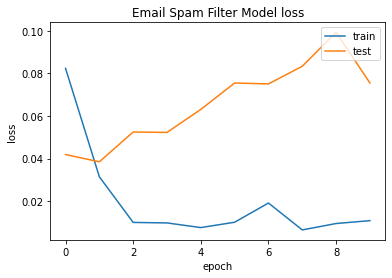

In [36]:

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Email Spam Filter Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

## Other Machine Learning Models

 We will build 3 more models and compare the performance in the same way. For this purpose we will use the same tf-idf as input feature . We will train following models : 
 
 * SVM 
 * Random Forest
 * XGboost

### Lets train the svm model 

In [37]:
spam_model_svm = svm.SVC(verbose=1)
spam_model_svm.fit(X_train,y_train)


[LibSVM]

SVC(verbose=1)

### Lets build random forest

In [38]:
from sklearn.ensemble import RandomForestClassifier


In [39]:
spam_model_rf = RandomForestClassifier(n_jobs=2, random_state=0,n_estimators=50)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
spam_model_rf.fit(X_train,y_train)


RandomForestClassifier(n_estimators=50, n_jobs=2, random_state=0)

### Lets train xgboost model

In [41]:
# Build xgboost also 
import xgboost as xgb

In [42]:
spam_model_xgboost = xgb.XGBClassifier()
spam_model_xgboost.fit(X_train,y_train)

C:\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:10:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# Evaluate Model Performance

## Lets prepare test data 

In [43]:

sample_texts,sample_target=prepare_model_input(tfidf_model,df_unseen_test,mode='')


shape of labels:  (10000,)
shape of data:  (10000, 4000)
 -----total Computation time for preparing model data = 3.8125 seconds


In [44]:
# lets write a function to create the dataframe of the results from all the models

In [49]:
model_dict={}
model_dict['random_forest']=spam_model_rf
model_dict['svm']=spam_model_svm
model_dict['deep_learning']=spam_model_dl
model_dict['xgboost']=spam_model_xgboost


def getResults(model_dict,sample_texts,sample_target):
    '''
    Get results from different models
    '''
    results=[]
    
    results_cm={}
    
    for name,model in model_dict.items():
#         print(name)
        tic1 = time.process_time()
        if name in 'deep_learning':
            predicted_sample = predict(sample_texts)
        else:    
            predicted_sample = model.predict(sample_texts)
        toc1 = time.process_time()
#         print(predicted_sample)

        cm=sklearn.metrics.confusion_matrix(sample_target, predicted_sample)
        results_cm[name]=cm
        
        total=len(predicted_sample)
        TP = cm[0][0]
        FP = cm[0][1]
        FN = cm[1][0]
        TN = cm[1][1]
        
        time_taken=round(toc1 - tic1,4)
        res=sklearn.metrics.precision_recall_fscore_support(sample_target, predicted_sample)
        results.append([name,np.mean(res[0]),np.mean(res[1]),np.mean(res[2]),total,TP,FP,FN,TN,str(time_taken)] )
        
        
    
    df_cols=['model','precision','recall','f1_score','Total_samples','TP','FP','FN','TN','execution_time']
    result_df=pd.DataFrame(results,columns=df_cols)
    
    return result_df,results_cm
    
    
        


NameError: name 'spam_model_dl' is not defined

## Results

In [ ]:
result_df,results_cm= getResults(model_dict,sample_texts,sample_target)
result_df

,model,precision,recall,f1_score,Total_samples,TP,FP,FN,TN,execution_time
0,random_forest,0.887624,0.896754,0.890721,10000,3743,338,732,5187,0.5935
1,svm,0.935807,0.947646,0.939390,10000,4026,55,540,5379,318.8586
2,deep_learning,0.990649,0.990723,0.990686,10000,4037,44,46,5873,5.4259
3,xgboost,0.882452,0.875857,0.878744,10000,3398,683,479,5440,0.4664


As we see, deep learning model does very well on the test data. The results from other models are close. I have tried this approach over multiple language emails and deep learning model is very consistent with the performance. XGboost also does very well. Please note that i have not optimized random forest and SVM much beyond the defaults. So they may have better performance with tuning. 


### Plot confusion Matrix for all the models

In [ ]:
def plot_heatmap(cm,title):
    df_cm2 = pd.DataFrame(cm, index = ['normal', 'spam'])
    df_cm2.columns=['normal','spam']

    ax = plt.axes()
    sns.heatmap(df_cm2, annot=True, fmt="d", linewidths=.5,ax=ax)
    ax.set_title(title)
    plt.show()

    
    return
    

### CM for Deep Learning Model

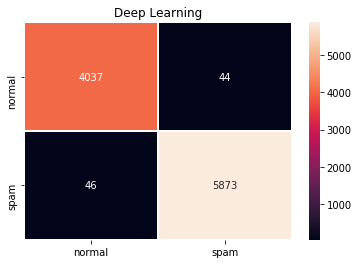

In [ ]:
plot_heatmap(results_cm['deep_learning'],'Deep Learning')

### CM for SVM Model

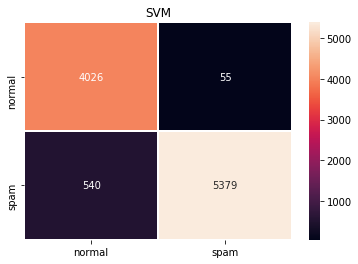

In [ ]:
plot_heatmap(results_cm['svm'],'SVM')

### CM for Random Forest Model

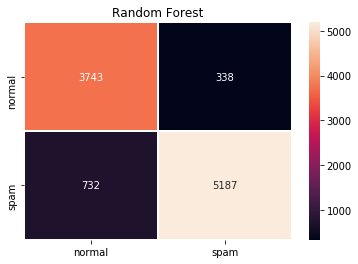

In [ ]:
plot_heatmap(results_cm['random_forest'],'Random Forest')

### CM for Xgboost

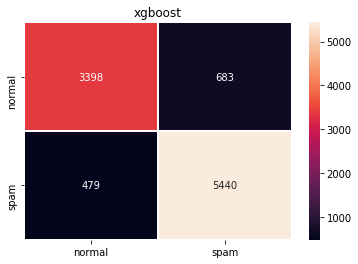

In [ ]:
plot_heatmap(results_cm['xgboost'],'xgboost')

The code and data for this project can be obtained at : 
https://github.com/sanjaymeena/Deep-Learning-based-Spam-Filter
